# Sprint 2

## Getting the dataset and cleaning the data: 

In [2]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [3]:
# choose your location
latitude = "40.7128"
longitude = "-74.0060"
grid_url = f"https://api.weather.gov/points/{latitude},{longitude}"
headers = {
    "User-Agent": "MyWeatherApp (kparekh2@terpmail.umd.edu)",
    "Accept": "application/geo+json"
}

grid_response = requests.get(grid_url, headers=headers)

if grid_response.status_code == 200:
    grid_data = grid_response.json()
    office = grid_data["properties"]["gridId"]
    grid_x = grid_data["properties"]["gridX"]
    grid_y = grid_data["properties"]["gridY"]

    # get the hourly forecast
    forecast_url = f"https://api.weather.gov/gridpoints/{office}/{grid_x},{grid_y}/forecast/hourly"
    forecast_response = requests.get(forecast_url, headers=headers)

    if forecast_response.status_code == 200:
        forecast_data = forecast_response.json()
        periods = forecast_data["properties"]["periods"]
        nws_forecast = pd.DataFrame({
            "datetime": [entry["startTime"] for entry in periods],
            "forecasted_temp_F": [entry["temperature"] for entry in periods],
            "wind_speed": [entry["windSpeed"] for entry in periods],
            "short_forecast": [entry["shortForecast"] for entry in periods]
        })
        nws_forecast["datetime"] = pd.to_datetime(nws_forecast["datetime"])

nws_forecast.head()

,datetime,forecasted_temp_F,wind_speed,short_forecast
0,2025-03-14 17:00:00-04:00,51,7 mph,Sunny
1,2025-03-14 18:00:00-04:00,51,7 mph,Mostly Clear
2,2025-03-14 19:00:00-04:00,50,7 mph,Partly Cloudy
3,2025-03-14 20:00:00-04:00,48,7 mph,Partly Cloudy
4,2025-03-14 21:00:00-04:00,46,6 mph,Mostly Cloudy


In [4]:
# METAR station
station = "KEWR"  # Newark Airport (close to NYC) 
metar_url = f"https://api.weather.gov/stations/{station}/observations"

# get METAR data
metar_response = requests.get(metar_url, headers=headers)

if metar_response.status_code == 200:
    metar_data = metar_response.json()["features"]
    metar_records = []
    for entry in metar_data:
        props = entry["properties"]
        if "temperature" in props and props["temperature"]["value"] is not None:
            metar_records.append({
                "datetime": pd.to_datetime(props["timestamp"]),
                "actual_temp_F": (props["temperature"]["value"] * 9/5) + 32,  # Convert C to F
                "wind_speed_actual": props["windSpeed"]["value"]
            })

    nws_actuals = pd.DataFrame(metar_records)
    nws_actuals["datetime"] = nws_actuals["datetime"].dt.round("h")

nws_actuals.head()

,datetime,actual_temp_F,wind_speed_actual
0,2025-03-14 20:00:00+00:00,51.98,20.52
1,2025-03-14 19:00:00+00:00,51.98,16.56
2,2025-03-14 18:00:00+00:00,53.06,20.52
3,2025-03-14 17:00:00+00:00,53.06,7.56
4,2025-03-14 16:00:00+00:00,51.08,5.40


In [5]:
# ensure merge_key exists
nws_actuals["merge_key"] = nws_actuals["datetime"].dt.strftime("%Y-%m-%d %H:00")
nws_forecast["merge_key"] = nws_forecast["datetime"].dt.strftime("%Y-%m-%d %H:00")

# convert datetime columns to remove timezone information
nws_forecast["datetime"] = pd.to_datetime(nws_forecast["datetime"]).dt.tz_localize(None)
nws_actuals["datetime"] = pd.to_datetime(nws_actuals["datetime"]).dt.tz_localize(None)

# perform an asof merge to match each forecast with the nearest available actual temperature
weather_df = pd.merge_asof(nws_forecast.sort_values("datetime"), 
                           nws_actuals.sort_values("datetime"), 
                           on="datetime",
                           direction="backward")

# compute temperature difference
weather_df["temp_difference"] = weather_df["forecasted_temp_F"] - weather_df["actual_temp_F"]

# change missing values to be correctly aligned
weather_df.loc[:, "actual_temp_F"] = weather_df["actual_temp_F"].ffill()

weather_df.head()

,datetime,forecasted_temp_F,wind_speed,short_forecast,merge_key_x,actual_temp_F,wind_speed_actual,merge_key_y,temp_difference
0,2025-03-14 17:00:00,51,7 mph,Sunny,2025-03-14 17:00,53.06,7.56,2025-03-14 17:00,-2.06
1,2025-03-14 18:00:00,51,7 mph,Mostly Clear,2025-03-14 18:00,53.06,20.52,2025-03-14 18:00,-2.06
2,2025-03-14 19:00:00,50,7 mph,Partly Cloudy,2025-03-14 19:00,51.98,16.56,2025-03-14 19:00,-1.98
3,2025-03-14 20:00:00,48,7 mph,Partly Cloudy,2025-03-14 20:00,51.98,20.52,2025-03-14 20:00,-3.98
4,2025-03-14 21:00:00,46,6 mph,Mostly Cloudy,2025-03-14 21:00,51.98,20.52,2025-03-14 20:00,-5.98


## Data Dictionary

In [6]:
# dictionary explaining the merged dataset
data_dictionary = pd.DataFrame({
    "Variable Name": [
        "datetime", "forecasted_temp_F", "wind_speed", "short_forecast", 
        "merge_key_x", "actual_temp_F", "wind_speed_actual", "merge_key_y", "temp_difference"
    ],
    "Description": [
        "Timestamp of the forecasted weather observation (hourly)",
        "Forecasted temperature in Fahrenheit from the NWS API",
        "Forecasted wind speed in mph from the NWS API",
        "Brief text description of forecasted weather conditions",
        "Key used to merge forecast and actual observations (datetime format)",
        "Actual recorded temperature in Fahrenheit from METAR (Newark Airport)",
        "Actual recorded wind speed in mph from METAR (Newark Airport)",
        "Key used for merging METAR actual temperature readings",
        "Difference between forecasted and actual temperature (forecasted_temp_F - actual_temp_F)"
    ],
    "Data Type": [
        "datetime", "float", "string", "string",
        "string", "float", "float", "string", "float"
    ],
    "Source": [
        "NWS API", "NWS API", "NWS API", "NWS API",
        "Computed Feature", "METAR API (NOAA)", "METAR API (NOAA)", "Computed Feature", "Computed Feature"
    ]
})
pd.options.display.max_colwidth = None #to show all the definitions 
data_dictionary

,Variable Name,Description,Data Type,Source
0,datetime,Timestamp of the forecasted weather observation (hourly),datetime,NWS API
1,forecasted_temp_F,Forecasted temperature in Fahrenheit from the NWS API,float,NWS API
2,wind_speed,Forecasted wind speed in mph from the NWS API,string,NWS API
3,short_forecast,Brief text description of forecasted weather conditions,string,NWS API
4,merge_key_x,Key used to merge forecast and actual observations (datetime format),string,Computed Feature
5,actual_temp_F,Actual recorded temperature in Fahrenheit from METAR (Newark Airport),float,METAR API (NOAA)
6,wind_speed_actual,Actual recorded wind speed in mph from METAR (Newark Airport),float,METAR API (NOAA)
7,merge_key_y,Key used for merging METAR actual temperature readings,string,Computed Feature
8,temp_difference,Difference between forecasted and actual temperature (forecasted_temp_F - actual_temp_F),float,Computed Feature


In [7]:
# remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# apply to temp_difference column
weather_df = remove_outliers(weather_df, "temp_difference")
weather_df.head()

,datetime,forecasted_temp_F,wind_speed,short_forecast,merge_key_x,actual_temp_F,wind_speed_actual,merge_key_y,temp_difference
0,2025-03-14 17:00:00,51,7 mph,Sunny,2025-03-14 17:00,53.06,7.56,2025-03-14 17:00,-2.06
1,2025-03-14 18:00:00,51,7 mph,Mostly Clear,2025-03-14 18:00,53.06,20.52,2025-03-14 18:00,-2.06
2,2025-03-14 19:00:00,50,7 mph,Partly Cloudy,2025-03-14 19:00,51.98,16.56,2025-03-14 19:00,-1.98
3,2025-03-14 20:00:00,48,7 mph,Partly Cloudy,2025-03-14 20:00,51.98,20.52,2025-03-14 20:00,-3.98
4,2025-03-14 21:00:00,46,6 mph,Mostly Cloudy,2025-03-14 21:00,51.98,20.52,2025-03-14 20:00,-5.98


In [8]:
from sklearn.preprocessing import StandardScaler

# convert wind_speed to numerical values
weather_df["wind_speed"] = weather_df["wind_speed"].str.extract("(\d+)").astype(float)

scaler = StandardScaler()
weather_df[["forecasted_temp_F", "actual_temp_F", "temp_difference", "wind_speed", "wind_speed_actual"]] = scaler.fit_transform(
    weather_df[["forecasted_temp_F", "actual_temp_F", "temp_difference", "wind_speed", "wind_speed_actual"]]
)
weather_df.head()

,datetime,forecasted_temp_F,wind_speed,short_forecast,merge_key_x,actual_temp_F,wind_speed_actual,merge_key_y,temp_difference
0,2025-03-14 17:00:00,-0.194950,-1.069609,Sunny,2025-03-14 17:00,8.774964,-11.904493,2025-03-14 17:00,-0.418191
1,2025-03-14 18:00:00,-0.194950,-1.069609,Mostly Clear,2025-03-14 18:00,8.774964,0.100469,2025-03-14 18:00,-0.418191
2,2025-03-14 19:00:00,-0.404689,-1.069609,Partly Cloudy,2025-03-14 19:00,-0.113961,-3.567714,2025-03-14 19:00,-0.401427
3,2025-03-14 20:00:00,-0.824167,-1.069609,Partly Cloudy,2025-03-14 20:00,-0.113961,0.100469,2025-03-14 20:00,-0.820532
4,2025-03-14 21:00:00,-1.243645,-1.252569,Mostly Cloudy,2025-03-14 21:00,-0.113961,0.100469,2025-03-14 20:00,-1.239637


## Data Visualizations

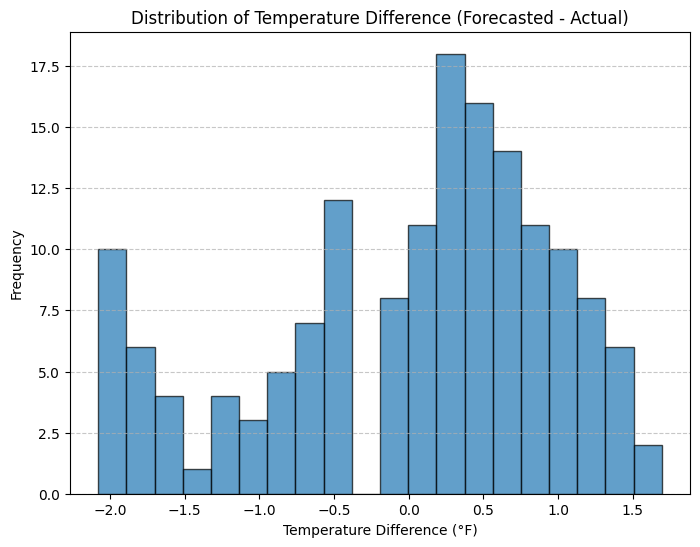

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(weather_df["temp_difference"], bins=20, edgecolor="black", alpha=0.7)
plt.xlabel("Temperature Difference (°F)")
plt.ylabel("Frequency")
plt.title("Distribution of Temperature Difference (Forecasted - Actual)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

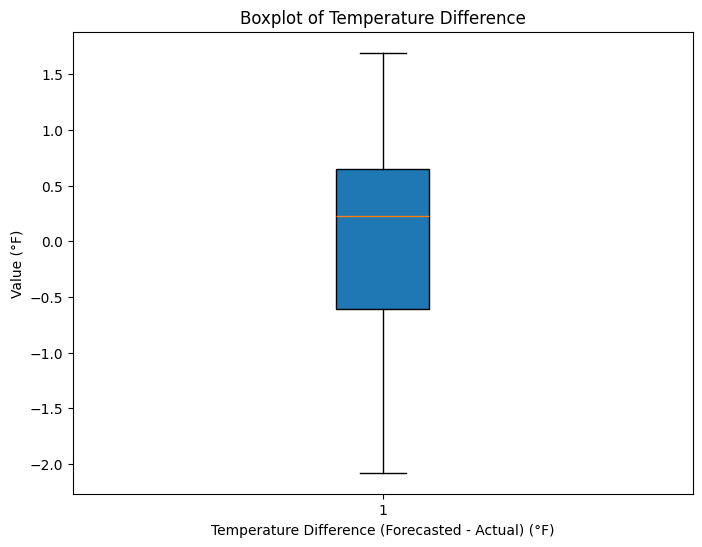

In [10]:
plt.figure(figsize=(8, 6))
plt.boxplot(weather_df["temp_difference"], vert=True, patch_artist=True)

# Labeling the boxplot
plt.xlabel("Temperature Difference (Forecasted - Actual) (°F)")
plt.ylabel("Value (°F)")
plt.title("Boxplot of Temperature Difference")

# Show the plot
plt.show()

## Feature Engineering

In [11]:
# creating day and hour 
weather_df["hour"] = weather_df["datetime"].dt.hour
weather_df["day_of_week"] = weather_df["datetime"].dt.dayofweek

# rolling mean
weather_df["rolling_temp_diff"] = weather_df["temp_difference"].rolling(window=3, min_periods=1).mean()

# wind spin into bins for categorization
weather_df["wind_speed_category"] = pd.cut(
    weather_df["wind_speed"], bins=[0, 5, 15, 30, 100], labels=["Low", "Medium", "High", "Very High"]
)

# lag feature
weather_df["temp_difference_lag1"] = weather_df["temp_difference"].shift(1)

# dropping NaN values
weather_df.dropna(inplace=True)
weather_df.head()

,datetime,forecasted_temp_F,wind_speed,short_forecast,merge_key_x,actual_temp_F,wind_speed_actual,merge_key_y,temp_difference,hour,day_of_week,rolling_temp_diff,wind_speed_category,temp_difference_lag1
33,2025-03-16 02:00:00,0.014789,0.028148,Areas Of Fog,2025-03-16 02:00,-0.113961,0.100469,2025-03-14 20:00,0.017678,2,6,-0.191875,Low,-0.191875
34,2025-03-16 03:00:00,0.014789,0.211107,Areas Of Fog,2025-03-16 03:00,-0.113961,0.100469,2025-03-14 20:00,0.017678,3,6,-0.052173,Low,0.017678
35,2025-03-16 04:00:00,0.224528,0.394067,Areas Of Fog,2025-03-16 04:00,-0.113961,0.100469,2025-03-14 20:00,0.227230,4,6,0.087528,Low,0.017678
36,2025-03-16 05:00:00,0.224528,0.577026,Areas Of Fog,2025-03-16 05:00,-0.113961,0.100469,2025-03-14 20:00,0.227230,5,6,0.157379,Low,0.227230
37,2025-03-16 06:00:00,0.224528,0.759986,Areas Of Fog,2025-03-16 06:00,-0.113961,0.100469,2025-03-14 20:00,0.227230,6,6,0.227230,Low,0.227230


## Baseline Model Implementation

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = weather_df.drop(columns=["temp_difference", "rolling_temp_diff", "temp_difference_lag1", "datetime", "merge_key_x", "merge_key_y"])
X = pd.get_dummies(X, columns=["wind_speed_category"], drop_first=True)
X = X.drop(columns=["short_forecast"])
y = weather_df["temp_difference"]

# scaling the features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#ridge regression model 

ridge_model = Ridge(alpha=1.0) 
ridge_model.fit(X_train, y_train)
ridge_preds = ridge_model.predict(X_test)

# random forest regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

#evaluating the models

def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Model Performance:")
    print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_true, y_pred):.4f}")
    print(f"R-Squared Score (R2): {r2_score(y_true, y_pred):.4f}")

evaluate_model("Ridge Regression", y_test, ridge_preds)
evaluate_model("Random Forest", y_test, rf_preds)

#cross validation
ridge_cv_score = cross_val_score(ridge_model, X_scaled, y, cv=5).mean()
rf_cv_score = cross_val_score(rf_model, X_scaled, y, cv=5).mean()

print(f"\nCross Validation Scores:\nRidge Regression: {ridge_cv_score:.4f}\nRandom Forest: {rf_cv_score:.4f}")


Ridge Regression Model Performance:
Mean Absolute Error (MAE): 0.0123
Mean Squared Error (MSE): 0.0003
R-Squared Score (R2): 0.9994

Random Forest Model Performance:
Mean Absolute Error (MAE): 0.0142
Mean Squared Error (MSE): 0.0005
R-Squared Score (R2): 0.9989

Cross Validation Scores:
Ridge Regression: 0.9921
Random Forest: 0.9382


## Model Evaluation and Comparison

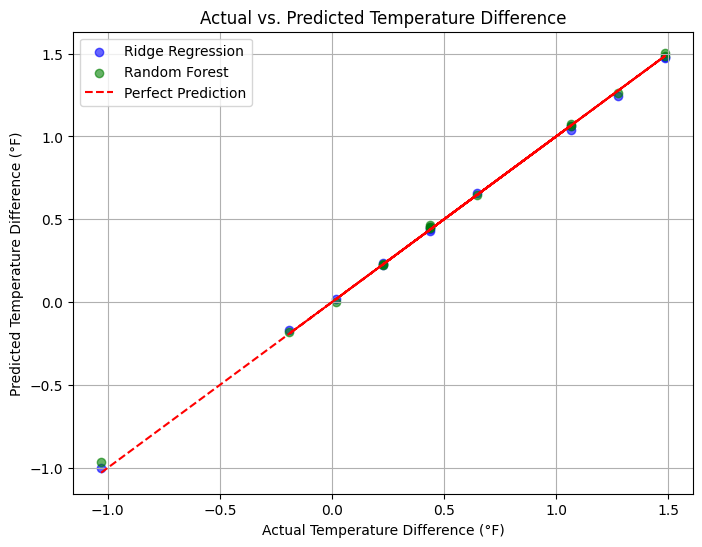

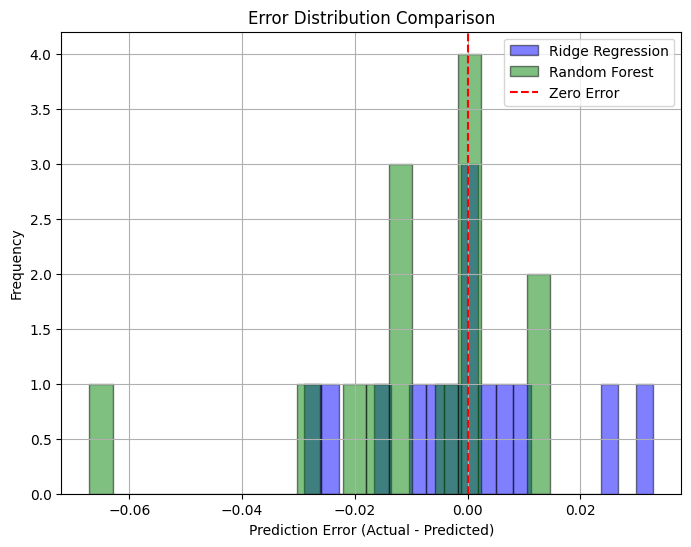

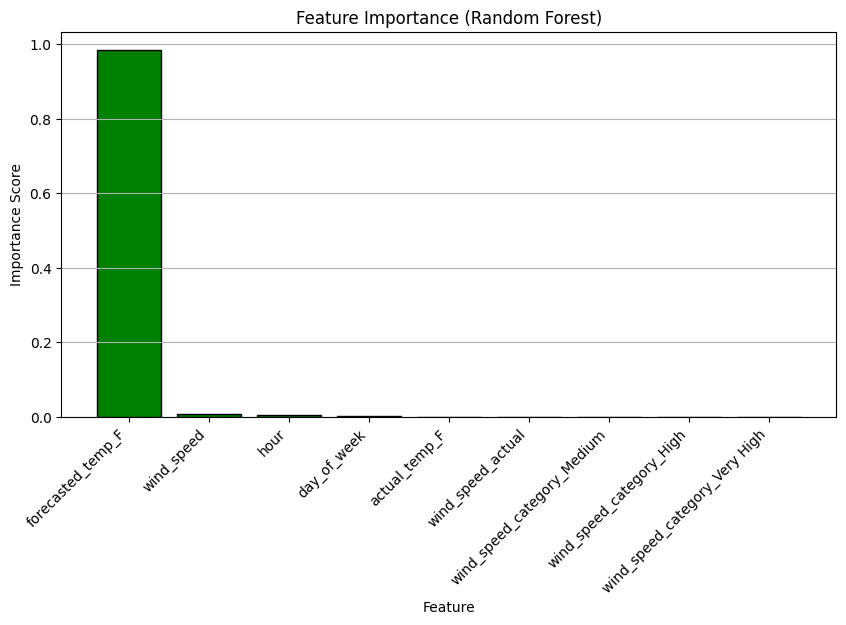

In [22]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, ridge_preds, alpha=0.6, label="Ridge Regression", color="blue")
plt.scatter(y_test, rf_preds, alpha=0.6, label="Random Forest", color="green")
plt.plot(y_test, y_test, color="red", linestyle="--", label="Perfect Prediction")
plt.xlabel("Actual Temperature Difference (°F)")
plt.ylabel("Predicted Temperature Difference (°F)")
plt.title("Actual vs. Predicted Temperature Difference")
plt.legend()
plt.grid()
plt.show()

ridge_errors = y_test - ridge_preds
rf_errors = y_test - rf_preds

plt.figure(figsize=(8, 6))
plt.hist(ridge_errors, bins=20, alpha=0.5, color="blue", label="Ridge Regression", edgecolor="black")
plt.hist(rf_errors, bins=20, alpha=0.5, color="green", label="Random Forest", edgecolor="black")
plt.axvline(0, color="red", linestyle="--", label="Zero Error")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Error Distribution Comparison")
plt.legend()
plt.grid()
plt.show()

rf_feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
plt.bar(rf_feature_importance.index, rf_feature_importance.values, color="green", edgecolor="black")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance (Random Forest)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.show()
